# 9. Neural Networks

## Prep

### Import packages and libraries

In [1]:
# Standard:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import os

# Tensorflow for network building:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras import regularizers

# GridSearch-like functionality from keras_tuner for optimal hyperparameters
from keras_tuner.tuners import RandomSearch

### Load data

Network architecture and hyperparameter optimisation will be don on the training dataset. Note that the datasets for neural networks will be used here, which contain some features that are co-linear and we trust the neural network to handle this.

In [2]:
X_train = pd.read_csv ('X_train_NN_4.csv', index_col = 0)
y_train = pd.read_csv ('y_train_4.csv', index_col = 0)

Scale the data. Previous experience with logistic regression and exploratory data analysis using t-SNE and UMAP plots indicates that the two groups are most differentiable after Min-Max scaling.

In [3]:
# Scale data using minmax scaler
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform (X_train)

## Network Building and Hyperparameter Testing

The performance of a neural network dependes on several hyperparameters related to the following:
- Architecture
    - number of layers
    - number of nodes
- Regularization and stability
    - regularization (e.g. l2)
    - drop-out layers (for preventing overfitting)
    - batch normalization
- Learning
    - activation function
    - loss function
    - optimizer  
  
Assessment of the network performance occurs at 2 stages. The first stage is during a setup and uses a validation subset of the data. Once the best model is selected and trained, the model is evaluated on the test data that it has never been exposed to. There are several metrics to evaluate a model for binary prediction including *accuracy*, *precision*, *recall* and *f1 metric*. Since our classes are perfectly balanced, accuracy will be used to optimise the model. For the final model performance assessment, all metrics will be calculated along with a ROC curve.

### Define network architecture and hyperparameter options

A function will be constructed for model building.

In [4]:
def build_model(hp):
    
    # Define the range of values for hyperparameters
    num_hidden_layers = hp.Int('num_hidden_layers', 3, 7, default=5) # 3 - 10 hidden layers
    num_nodes = hp.Int('num_nodes', 49, 294, step=49, default=147) # 49 - 588 nodes
    l2_regularization = hp.Choice('l2_regularization', [0.01, 0.1, 1.0, 10.0])
    activation = hp.Choice('activation', ['relu', 'tanh'])
    optimizer = hp.Choice('optimizer', ['adam', 'adamax'])
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])
    
    # Instantiate a tensorflow sequential model
    model = keras.Sequential()
    
    # First layer always contains the number of features as defined in input_shape
    model.add(layers.Dense(input_shape[0], activation=activation, input_shape=input_shape))   
    
    
    # Add the hidden layers such that
    for i in range(num_hidden_layers):
        if i == (num_hidden_layers - 1): # last layer can choose between relu and tanh activation
            activation = hp.Choice ('activation', ['relu', 'tanh'])
        else:
            activation = 'relu' # inner hidden layers are all relu
            
        model.add(layers.Dense(num_nodes, # add layers with random nodes
                               activation = activation, # choose activation function
                               kernel_regularizer = tf.keras.regularizers.l2( # regularize
                                   l2_regularization)))

    # Add the output layer
    model.add(layers.Dense(1, activation='sigmoid')) # Output layer for binary class.

    # Compile the model and choose between Adam and Adamax optimisers
    if optimizer == 'adam': 
        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    else:
        opt = tf.keras.optimizers.Adamax(learning_rate = learning_rate)
        
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

The following parameters for optimization are input:
- Architecture
    - number of layers (3 - 10)
    - number of nodes
        - minimun is the number of features divided by 3 (49)
        - maximum is the number of features multiplied by 2 (294)
- Regularization and stability
    - regularization (l2 with values of 0.01, 0.1, 1 and 10)
    - drop-out layers (None)
        - No dropouts are applied as regularisation is expected to largely handle overfitting
    - batch normalization (None)
        - Increases computational demands and more suitable for larger models
- Learning
    - activation function
        - RElu for all hidden layers of the network except the last one. Useful for non-linear transformations
        - Tanh or Relu for the last hidden layer
    - loss function
        - binary cross-entropy is conventional for binary classification problems
    - optimizer
        - Adam
        - Adamax

### Define hyperparameters for the grid search

Obtain the number of features and save in `input_shape` variable to be passed to the model building function.

In [5]:
# Specify the input shape
input_shape = (Xtrain_scaled.shape[1],)

In [9]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy', # validation accuracy to assess performance
    max_trials=200,  # Number of hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train per trial
    directory='NN_prediabetes_dir',  # Directory to store the results
    project_name='prediabetes_project'  # Name for the project
)

250 unique combinations of hyperparameters will be selected at random to assess the effect on the model despite the fact that there are 1000+ combinations.

### Grid search for best neural network

Perform the gird search to discover best performing hyperparameters.  
500 training epochs will be used for each model.  
Validation will be performed on a validation set by splitting the training data into 30% for validation and 70% for test every time a new model is instantiated.  
The training will also be monitored and the fitting will be stopped early if there is no improvement of the validation loss for 80 epochs.

In [10]:
monitor = tf.keras.callbacks.EarlyStopping( # early stopping if
    monitor='val_loss', # The validation loss does not improve
    patience=15) # for 15 epochs

In [11]:
# Step 4: Perform grid search with cross-validation
tuner.search(Xtrain_scaled, y_train, epochs=100, validation_split=0.3, callbacks=[monitor])

Trial 20 Complete [01h 04m 38s]
val_accuracy: 0.9251552820205688

Best val_accuracy So Far: 0.9273678064346313
Total elapsed time: 05h 57m 29s
INFO:tensorflow:Oracle triggered exit


### Build the final neural network based on the best performing hyperparameters

In [ ]:
# Get the best hyperparameters and train the final model
best_hp = tuner.get_best_hyperparameters()[0]

In [19]:
# Display the hyperparameters
for hp_name, hp_value in best_hp.values.items():
    print(f"{hp_name}: {hp_value}")

num_hidden_layers: 3
num_nodes: 98
l2_regularization: 0.01
activation: relu
optimizer: adam
learning_rate: 0.001


Build a network based on the best hyperparameters discovered and train it on the entirety of the train sets.

In [23]:
# Build the best neural network model using all the train dataset
model = tuner.hypermodel.build(best_hp)

In [24]:
early_stop = tf.keras.callbacks.EarlyStopping (
    monitor = 'val_loss',
    patience = 20
)

In [25]:
model.fit(Xtrain_scaled, 
          y_train, 
          epochs=1000, 
          validation_split=0.1
         )

Epoch 1/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1951 - accuracy: 0.9175 - val_loss: 0.1587 - val_accuracy: 0.9223
Epoch 2/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1597 - accuracy: 0.9214 - val_loss: 0.1613 - val_accuracy: 0.9189
Epoch 3/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1558 - accuracy: 0.9218 - val_loss: 0.1568 - val_accuracy: 0.9204
Epoch 4/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1538 - accuracy: 0.9223 - val_loss: 0.1543 - val_accuracy: 0.9241
Epoch 5/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1522 - accuracy: 0.9226 - val_loss: 0.1500 - val_accuracy: 0.9247
Epoch 6/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1514 - accuracy: 0.9226 - val_loss: 0.1480 - val_accuracy: 0.9256
Epoch 7/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1507 - accuracy: 0.9231

16229/16229 [==============================] - 19s 1ms/step - loss: 0.1379 - accuracy: 0.9266 - val_loss: 0.1375 - val_accuracy: 0.9284
Epoch 110/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1379 - accuracy: 0.9268 - val_loss: 0.1452 - val_accuracy: 0.9205
Epoch 111/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1378 - accuracy: 0.9269 - val_loss: 0.1382 - val_accuracy: 0.9280
Epoch 112/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1378 - accuracy: 0.9269 - val_loss: 0.1399 - val_accuracy: 0.9275
Epoch 113/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1378 - accuracy: 0.9266 - val_loss: 0.1374 - val_accuracy: 0.9280
Epoch 114/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1377 - accuracy: 0.9267 - val_loss: 0.1393 - val_accuracy: 0.9251
Epoch 115/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1376 - accuracy: 0.9267 

16229/16229 [==============================] - 19s 1ms/step - loss: 0.1357 - accuracy: 0.9275 - val_loss: 0.1387 - val_accuracy: 0.9276
Epoch 218/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1357 - accuracy: 0.9275 - val_loss: 0.1374 - val_accuracy: 0.9284
Epoch 219/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1356 - accuracy: 0.9280 - val_loss: 0.1377 - val_accuracy: 0.9276
Epoch 220/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1356 - accuracy: 0.9280 - val_loss: 0.1379 - val_accuracy: 0.9273
Epoch 221/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1356 - accuracy: 0.9274 - val_loss: 0.1371 - val_accuracy: 0.9281
Epoch 222/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1356 - accuracy: 0.9276 - val_loss: 0.1373 - val_accuracy: 0.9280
Epoch 223/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1356 - accuracy: 0.9276 

16229/16229 [==============================] - 19s 1ms/step - loss: 0.1345 - accuracy: 0.9282 - val_loss: 0.1370 - val_accuracy: 0.9269
Epoch 326/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1345 - accuracy: 0.9280 - val_loss: 0.1361 - val_accuracy: 0.9284
Epoch 327/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1345 - accuracy: 0.9279 - val_loss: 0.1367 - val_accuracy: 0.9277
Epoch 328/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1345 - accuracy: 0.9278 - val_loss: 0.1357 - val_accuracy: 0.9291
Epoch 329/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1345 - accuracy: 0.9281 - val_loss: 0.1359 - val_accuracy: 0.9274
Epoch 330/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1345 - accuracy: 0.9281 - val_loss: 0.1371 - val_accuracy: 0.9284
Epoch 331/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1346 - accuracy: 0.9281 

16229/16229 [==============================] - 19s 1ms/step - loss: 0.1340 - accuracy: 0.9284 - val_loss: 0.1373 - val_accuracy: 0.9284
Epoch 434/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1340 - accuracy: 0.9284 - val_loss: 0.1354 - val_accuracy: 0.9286
Epoch 435/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1340 - accuracy: 0.9284 - val_loss: 0.1372 - val_accuracy: 0.9286
Epoch 436/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1340 - accuracy: 0.9285 - val_loss: 0.1363 - val_accuracy: 0.9280
Epoch 437/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1340 - accuracy: 0.9282 - val_loss: 0.1363 - val_accuracy: 0.9279
Epoch 438/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1340 - accuracy: 0.9283 - val_loss: 0.1361 - val_accuracy: 0.9285
Epoch 439/1000
16229/16229 [==============================] - 19s 1ms/step - loss: 0.1339 - accuracy: 0.9283 

16229/16229 [==============================] - 18s 1ms/step - loss: 0.1336 - accuracy: 0.9286 - val_loss: 0.1404 - val_accuracy: 0.9275
Epoch 542/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1337 - accuracy: 0.9284 - val_loss: 0.1357 - val_accuracy: 0.9292
Epoch 543/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1335 - accuracy: 0.9283 - val_loss: 0.1372 - val_accuracy: 0.9285
Epoch 544/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1337 - accuracy: 0.9284 - val_loss: 0.1352 - val_accuracy: 0.9289
Epoch 545/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1337 - accuracy: 0.9285 - val_loss: 0.1354 - val_accuracy: 0.9291
Epoch 546/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1336 - accuracy: 0.9285 - val_loss: 0.1355 - val_accuracy: 0.9286
Epoch 547/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1336 - accuracy: 0.9287 

16229/16229 [==============================] - 18s 1ms/step - loss: 0.1334 - accuracy: 0.9288 - val_loss: 0.1360 - val_accuracy: 0.9279
Epoch 650/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1333 - accuracy: 0.9287 - val_loss: 0.1363 - val_accuracy: 0.9278
Epoch 651/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1333 - accuracy: 0.9286 - val_loss: 0.1371 - val_accuracy: 0.9281
Epoch 652/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1333 - accuracy: 0.9289 - val_loss: 0.1369 - val_accuracy: 0.9270
Epoch 653/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1333 - accuracy: 0.9286 - val_loss: 0.1362 - val_accuracy: 0.9279
Epoch 654/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1333 - accuracy: 0.9287 - val_loss: 0.1350 - val_accuracy: 0.9287
Epoch 655/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1332 - accuracy: 0.9285 

16229/16229 [==============================] - 18s 1ms/step - loss: 0.1331 - accuracy: 0.9288 - val_loss: 0.1367 - val_accuracy: 0.9279
Epoch 758/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1332 - accuracy: 0.9290 - val_loss: 0.1367 - val_accuracy: 0.9281
Epoch 759/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1332 - accuracy: 0.9287 - val_loss: 0.1363 - val_accuracy: 0.9275
Epoch 760/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1331 - accuracy: 0.9288 - val_loss: 0.1372 - val_accuracy: 0.9278
Epoch 761/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1331 - accuracy: 0.9290 - val_loss: 0.1380 - val_accuracy: 0.9256
Epoch 762/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1331 - accuracy: 0.9287 - val_loss: 0.1369 - val_accuracy: 0.9284
Epoch 763/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1331 - accuracy: 0.9288 

16229/16229 [==============================] - 18s 1ms/step - loss: 0.1330 - accuracy: 0.9289 - val_loss: 0.1355 - val_accuracy: 0.9286
Epoch 866/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1328 - accuracy: 0.9291 - val_loss: 0.1364 - val_accuracy: 0.9265
Epoch 867/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1329 - accuracy: 0.9290 - val_loss: 0.1356 - val_accuracy: 0.9284
Epoch 868/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1330 - accuracy: 0.9290 - val_loss: 0.1351 - val_accuracy: 0.9290
Epoch 869/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1328 - accuracy: 0.9291 - val_loss: 0.1375 - val_accuracy: 0.9277
Epoch 870/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1329 - accuracy: 0.9289 - val_loss: 0.1368 - val_accuracy: 0.9265
Epoch 871/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1329 - accuracy: 0.9287 

16229/16229 [==============================] - 18s 1ms/step - loss: 0.1328 - accuracy: 0.9288 - val_loss: 0.1353 - val_accuracy: 0.9289
Epoch 974/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1327 - accuracy: 0.9292 - val_loss: 0.1359 - val_accuracy: 0.9284
Epoch 975/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1327 - accuracy: 0.9290 - val_loss: 0.1371 - val_accuracy: 0.9287
Epoch 976/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1328 - accuracy: 0.9289 - val_loss: 0.1361 - val_accuracy: 0.9285
Epoch 977/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1327 - accuracy: 0.9290 - val_loss: 0.1360 - val_accuracy: 0.9283
Epoch 978/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1328 - accuracy: 0.9291 - val_loss: 0.1359 - val_accuracy: 0.9276
Epoch 979/1000
16229/16229 [==============================] - 18s 1ms/step - loss: 0.1327 - accuracy: 0.9290 

In [26]:
# Save trained model
model.save ('best_NN_model_minmax.h5')

## Neural Network Model Evaluation

In [ ]:
X_test = pd.read_csv ('X_test_NN_4.csv', index_col = 0)
y_test = pd.read_csv ('y_test_4.csv', index_col = 0)

In [ ]:
y_test = y_test.prediabetes_bin_y

In [86]:
# Scale test data:
Xtest_scaled = scaler.transform (X_test)

In [87]:
# Prediction and extract positive probabilities
y_pred_prob = model.predict(Xtest_scaled)

7728/7728 [==============================] - 5s 700us/step


In [88]:
# Flatten the np.array to get a list
y_pred_prob_list = y_pred_prob.flatten()

In [89]:
# Obtain predictions from the probabilities using a threshold of 0.5:
y_pred = (y_pred_prob > 0.5).astype(int)
y_pred_list = y_pred.flatten()

In [91]:
# Obtain metrics for ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_list)

In [93]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_list)

# Calculate recall
recall = recall_score(y_test, y_pred_list)

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_list)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_prob_list)

# Calculate recall
precision = precision_score(y_test, y_pred_list)

# Calculate recall
f1 = f1_score(y_test, y_pred_list)

In [1]:
# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_prob_list)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.text(0.6, 0.3, ('AUC = ' + str(round(auc_score, 4))), fontsize = 16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nthreshold = 0.5')
plt.legend(loc='lower right')
plt.show()

NameError: name 'roc_auc_score' is not defined

In [95]:
# Print metrics for model performance:
print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 score:', f1)

Accuracy: 0.9247893178913996
Recall: 0.9845203241512058
Precision: 0.879458448023003
F1 score: 0.929028516043852


In [102]:
# Check accuracy for different thresholds

thresholds = np.linspace(0.1, 0.97, 9)
thresholds = np.append (thresholds, 0.5)
thresholds = np.sort (thresholds)

In [104]:
y_pred_prob_list

array([9.9988836e-01, 9.9988782e-01, 2.2372172e-08, ..., 3.1301795e-07,
       6.7470599e-12, 6.7189115e-01], dtype=float32)

In [ ]:
# Define lists to hold metrics:
accuracies = []
precisions = []
recalls = []
f1s = []

# Obtain model metrics for each decision threshold
for v in thresholds:
    print (v)
    predictions = (y_pred_prob_list > v).astype(int)
    # Obtain metrics
    accuracies.append ( accuracy_score(y_test, predictions) )
    precisions.append ( precision_score(y_test, predictions) )
    recalls.append ( recall_score(y_test, predictions) )
    f1s.append ( f1_score(y_test, predictions) )

# Print dataframe with metrics corresponding to each threshold
metrics_thresholds = pd.DataFrame (
    {
        'threshold' : thresholds,
        'accuracy' : accuracies,
        'precision' : precisions,
        'recall' : recalls,
        'f1 score' : f1s
    }
)

<a id='metrics'></a>

In [105]:
display (metrics_thresholds)

0.1
0.20875
0.3175
0.42625
0.5
0.535
0.6437499999999999
0.7525
0.86125
0.97


,threshold,accuracy,precision,recall,f1 score
0,0.10000,0.916993,0.857965,0.999442,0.923315
1,0.20875,0.918238,0.860109,0.998949,0.924345
2,0.31750,0.920709,0.864912,0.997161,0.926341
3,0.42625,0.923119,0.871480,0.992624,0.928116
4,0.50000,0.924789,0.879458,0.984520,0.929029
5,0.53500,0.927195,0.894734,0.968313,0.930071
6,0.64375,0.921376,0.923786,0.918534,0.921152
7,0.75250,0.889572,0.986016,0.790353,0.877408
8,0.86125,0.882762,0.995809,0.768759,0.867677
9,0.97000,0.878949,0.999052,0.758617,0.862390


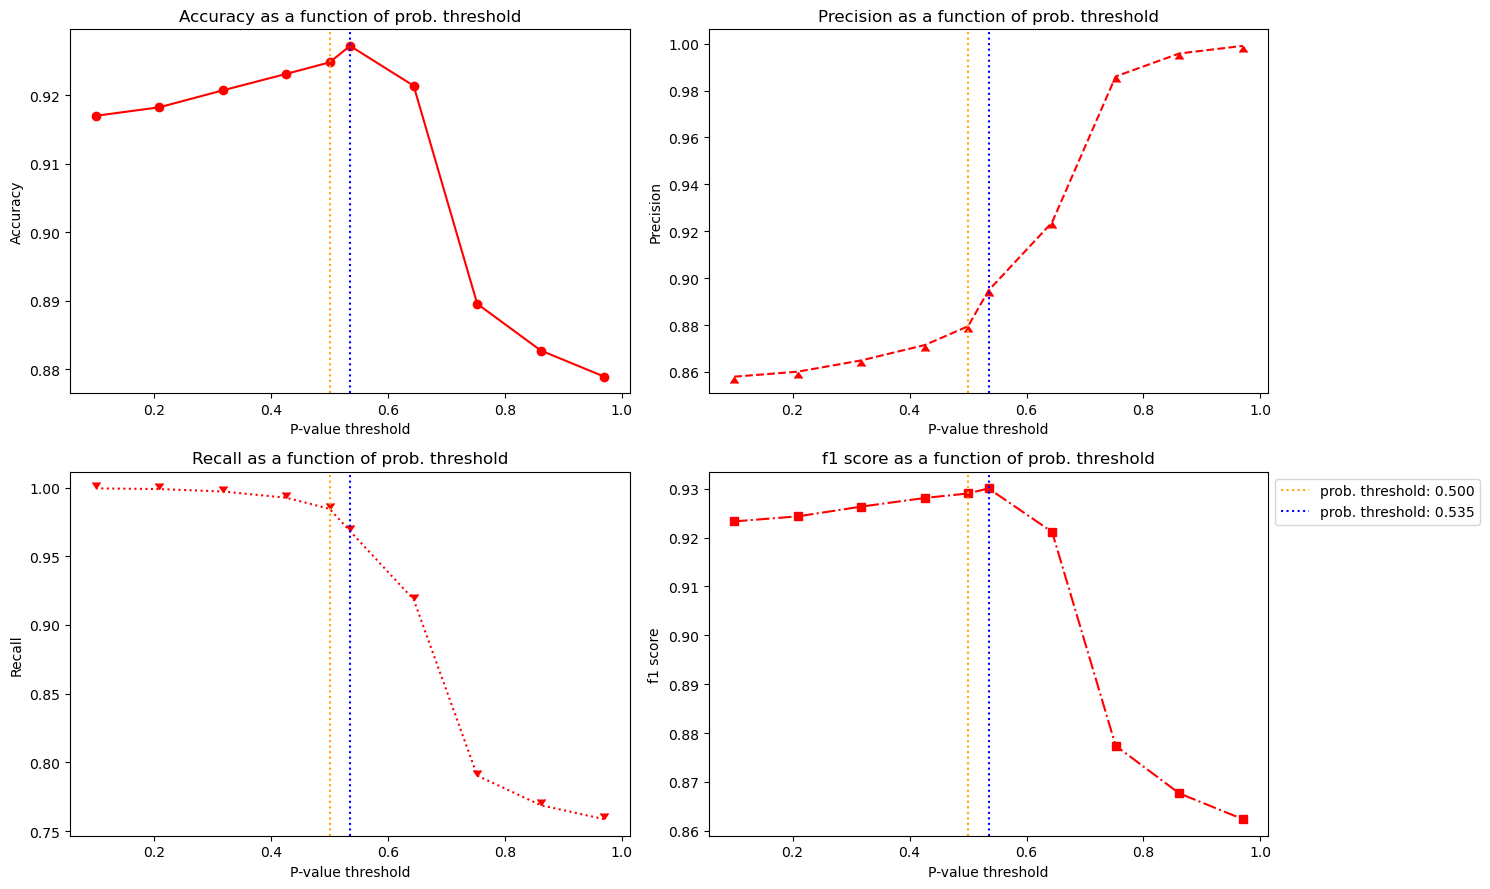

In [106]:
# Plot results and indicate 0.5 threshold and metrics with best precision and recall (0.535)
    
# Plot train and test metrics in 3 separate panels
# Plotting the results
fig, axes = plt.subplots(2, 2, figsize=(15, 9))

# Plot accuracy
axes[0, 0].plot(thresholds,
             accuracies,
             marker = 'o',
             color = 'red'
            )
axes[0, 0].axvline (x = 0.5,                  
                 color = 'orange',
                 linestyle = ':')
axes[0, 0].axvline (x = 0.535, 
                 color = 'blue',
                 linestyle = ':')
axes[0, 0].set_xlabel ('P-value threshold')
axes[0, 0].set_ylabel ('Accuracy')
axes[0, 0].set_title ('Accuracy as a function of prob. threshold')

# Plot precision
axes[0, 1].plot(thresholds,
             precisions,
             marker = 6,
             linestyle = '--',
             color = 'red'
            )
axes[0, 1].axvline (x = 0.5,                  
                 color = 'orange',
                 linestyle = ':')
axes[0, 1].axvline (x = 0.535, 
                 color = 'blue',
                 linestyle = ':')
axes[0, 1].set_xlabel ('P-value threshold')
axes[0, 1].set_ylabel ('Precision')
axes[0, 1].set_title ('Precision as a function of prob. threshold')

# Plot recall
axes[1, 0].plot(thresholds,
             recalls,
             marker = 7,
             linestyle = ':',
             color = 'red'
            )
axes[1, 0].axvline (x = 0.5,                  
                 color = 'orange',
                 linestyle = ':')
axes[1, 0].axvline (x = 0.535, 
                 color = 'blue',
                 linestyle = ':')
axes[1, 0].set_xlabel ('P-value threshold')
axes[1, 0].set_ylabel ('Recall')
axes[1, 0].set_title ('Recall as a function of prob. threshold')

# Plot f1 score
axes[1, 1].plot(thresholds,
             f1s,
             marker = 's',
             linestyle = '-.',
             color = 'red'
            )
axes[1, 1].axvline (x = 0.5,                 
                 color = 'orange',
                 linestyle = ':',
                   label = 'prob. threshold: 0.500')
axes[1, 1].axvline (x = 0.535, 
                 color = 'blue',
                 linestyle = ':',
                    label = 'prob. threshold: 0.535'
                   )
axes[1, 1].set_xlabel ('P-value threshold')
axes[1, 1].set_ylabel ('f1 score')
axes[1, 1].set_title ('f1 score as a function of prob. threshold')

# place legend outside
last_plot_ax = axes[1, 1]
last_plot_ax.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

plt.tight_layout()

plt.show()

The best choice for setting the classification probability threshold for prediabetes appears to be 0.535. It provides gains in overall accuracy, test precision and a slight decrease in recall. Moreover, the f1 score (the optimal balance between precision and recall) is highest for classification p-value threshold of 0.535.  
  
  
Therefore the best metrics (as displayed [above](#metrics)) are:
- accuracy - 0.927195
- precision - 0.894734 (89% chance the prediction is correct)
- recall - 0.968313 (capture 96% of all potential cases)
- f1 score - 0.930071

---